# Introduction

## Reference:

https://www.kaggle.com/nidhirastogi/intrusion-detection/data

## Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matplot
import numpy as np

import re
import sklearn

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

df_train = pd.read_csv('../input/Train_data.csv')
df_test = pd.read_csv('../input/test_data.csv')
df_test = df_test.drop('Unnamed: 0',axis=1)

## Exploring the data 

Data has 42 columns: duration, protocol_type, src_bytes, wrong_fragment, etc.

Training set has 125973 and Test set has 10000 samples

In [2]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack
0,0,icmp,20,2,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,45,2,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,icmp,50,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos
3,0,icmp,25,2,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,icmp,25,2,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [3]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack
0,0,icmp,25,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,110,110,1.0,1.0,0.0,0.0,1.0,0.0,0.00,255,255,1.00,0.00,0.00,0.00,0.65,0.65,0.32,0.32,dos
1,0,icmp,25,2,312,1856,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,9,0.0,0.0,0.0,0.0,1.0,0.0,0.33,1,254,1.00,0.00,1.00,0.06,0.00,0.00,0.00,0.00,normal
2,0,icmp,25,2,245,2058,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,0.0,0.0,1.0,0.0,0.00,114,255,1.00,0.00,0.01,0.05,0.01,0.00,0.00,0.00,normal
3,0,icmp,25,2,298,1267,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,18,0.0,0.0,0.0,0.0,1.0,0.0,0.11,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
4,0,icmp,20,2,740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,104,19,0.18,0.03,0.18,0.00,0.00,0.00,0.00,0.00,normal


## Save training dataset and test dateaset to each df and split X and Y (xAttack, analysis features). 

Using the 41 attributes from both training and testing dataset to classify whether it is an attack(DOS/R2L/Probe/U2R/Normal)[5 labels]

In [4]:
X_train = df_train.drop('xAttack', axis=1)
Y_train = df_train.loc[:,['xAttack']]
X_test = df_test.drop('xAttack', axis=1)
Y_test = df_test.loc[:,['xAttack']]

In [5]:
print(Y_train.apply(lambda col: col.unique()))

  xAttack
0  normal
1     dos
2     r2l
3   probe
4     u2r


## Preprocessing and one hot encoding, X is onehotencoder, Y is LabelBinarizer

In [6]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [7]:
le = preprocessing.LabelEncoder()
enc = OneHotEncoder()
lb = preprocessing.LabelBinarizer()

### X OneHotEncoding

In [8]:
X_train['protocol_type'] = le.fit_transform(X_train['protocol_type'])
# enc.fit_transform(X_train['protocol_type'])

X_test['protocol_type'] = le.fit_transform(X_test['protocol_type'])
# enc.fit_transform(X_test['protocol_type'])

X_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,20,2,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,2,45,2,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,0,50,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,0,25,2,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,0,25,2,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Y LabelBinarizer

In [9]:
Y_train['xAttack'] = le.fit_transform(Y_train['xAttack'])
lb.fit_transform(Y_train['xAttack'])

Y_test['xAttack'] = le.fit_transform(Y_test['xAttack'])
lb.fit_transform(Y_test['xAttack'])

Y_train.describe()

,xAttack
count,125973.000000
mean,0.744985
std,0.653748
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,4.000000


### 1. Standard deviation
We have applied a method to exclude features with small standard deviation (small deviation). However, when the feature type is discrete, the deviation is small.

In [10]:
#except continuous feature
con_list = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'su_attempted', 'is_host_login', 'is_guest_login']
con_train = X_train.drop(con_list, axis=1)

#drop n smallest std features
stdtrain = con_train.std(axis=0)
std_X_train = stdtrain.to_frame()
std_X_train.nsmallest(10, columns=0).head(10)

,0
num_outbound_cmds,0.000000
urgent,0.014366
num_shells,0.022181
root_shell,0.036603
num_failed_logins,0.045239
num_access_files,0.099370
dst_host_srv_diff_host_rate,0.112564
diff_srv_rate,0.180314
dst_host_diff_srv_rate,0.188922
wrong_fragment,0.253530


num_outbound_cmds is removed from the first because the standard deviation is zero.

In [11]:
X_train = X_train.drop(['num_outbound_cmds'], axis=1)
X_test = X_test.drop(['num_outbound_cmds'], axis=1)

df_train = pd.concat([X_train, Y_train], axis=1)
df_train.head()

X_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,20,2,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,2,45,2,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,0,50,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,0,25,2,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,0,25,2,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Std picks the 10 low and stores the features in drop -> X_train_stdrop. (Will be used after ensemble feature selection)

In [12]:
stdrop_list = ['urgent', 'num_shells', 'root_shell',
        'num_failed_logins', 'num_access_files', 'dst_host_srv_diff_host_rate',
        'diff_srv_rate', 'dst_host_diff_srv_rate', 'wrong_fragment']

X_test_stdrop = X_test.drop(stdrop_list, axis=1)

X_train_stdrop = X_train.drop(stdrop_list, axis=1)

df_train_stdrop = pd.concat([X_train_stdrop, Y_train], axis=1)

df_train_stdrop.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,hot,logged_in,num_compromised,su_attempted,num_root,num_file_creations,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_same_src_port_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack
0,0,0,20,2,491,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,150,25,0.17,0.17,0.00,0.00,0.05,0.00,1
1,0,2,45,2,146,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.00,255,1,0.00,0.88,0.00,0.00,0.00,0.00,1
2,0,0,50,4,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.00,255,26,0.10,0.00,1.00,1.00,0.00,0.00,0
3,0,0,25,2,232,8153,0,0,1,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,30,255,1.00,0.03,0.03,0.01,0.00,0.01,1
4,0,0,25,2,199,420,0,0,1,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,1


Baseline - Learn about performance with linear regression

- Linear regression

In [13]:
from sklearn import linear_model

In [14]:
LR = linear_model.LinearRegression()

In [15]:
LR.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
lr_score = LR.score(X_test, Y_test)
print('Linear regression processing ,,,')
print('Linear regression Score: %.2f %%' % lr_score)

Linear regression processing ,,,
Linear regression Score: 0.33 %


The linear regression yields only 33% probability.

### 2. Ensemble feature selection
Ensemble Modeling can see how the feature affected each model. Therefore, we tried feature selection around those features (attempt to remove Irrelevant feature).

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier

In [18]:
AB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, learning_rate=1.0)
RF = RandomForestClassifier(n_estimators=10, criterion='entropy', max_features='auto', bootstrap=True)
ET = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)
GB = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, max_features='auto')

In [19]:
y_train = Y_train['xAttack'].ravel()
x_train = X_train.values
x_test = X_test.values

Check the feature importances to see how accurate the basic features are.

In [20]:
AB.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [21]:
AB_feature = AB.feature_importances_
AB_feature

ab_score = AB.score(X_test, Y_test)

print('AdaBoostClassifier processing ,,,')
print('AdaBoostClassifier Score: %.3f %%' % ab_score)

AdaBoostClassifier processing ,,,
AdaBoostClassifier Score: 0.760 %


In [22]:
RF.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
RF_feature = RF.feature_importances_
RF_feature

rf_score = RF.score(X_test, Y_test)

print('RandomForestClassifier processing ,,,')
print('RandomForestClassifier Score: %.3f %%' % rf_score)

RandomForestClassifier processing ,,,
RandomForestClassifier Score: 0.754 %


In [24]:
ET.fit(X_train, Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [25]:
ET_feature = ET.feature_importances_
ET_feature

et_score = ET.score(X_test, Y_test)

print('ExtraTreesClassifier processing ,,,')
print('ExtraTreeClassifier: %.3f %%' % et_score)

ExtraTreesClassifier processing ,,,
ExtraTreeClassifier: 0.750 %


In [26]:
GB.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [27]:
GB_feature = GB.feature_importances_
GB_feature

gb_score = GB.score(X_test, Y_test)

print('GradientBoostingClassifier processing ,,,')
print('GradientBoostingClassifier Score: %.3f %%' % gb_score)

GradientBoostingClassifier processing ,,,
GradientBoostingClassifier Score: 0.763 %


Let's look at how the features affect each other through Ensemble

In [28]:
cols = X_train.columns.values

feature_df = pd.DataFrame({'features': cols,
                           'AdaBoost' : AB_feature,
                           'RandomForest' : RF_feature,
                           'ExtraTree' : ET_feature,
                           'GradientBoost' : GB_feature
                          })
feature_df.head(8)

,features,AdaBoost,RandomForest,ExtraTree,GradientBoost
0,duration,0.006689,0.002997,0.001453,0.002371
1,protocol_type,0.079839,0.017053,0.036040,0.010060
2,service,NaN,0.022174,0.013792,0.008046
3,flag,0.006223,0.005469,0.008611,0.001260
4,src_bytes,NaN,0.226202,0.023415,0.337479
5,dst_bytes,inf,0.071350,0.006323,0.080590
6,land,0.000005,0.000090,0.000042,0.000050
7,wrong_fragment,0.008147,0.007525,0.015028,0.012979


Graphs showing the influence of features

[Text(0,0,'duration'),
 Text(0,0,'protocol_type'),
 Text(0,0,'service'),
 Text(0,0,'flag'),
 Text(0,0,'src_bytes'),
 Text(0,0,'dst_bytes'),
 Text(0,0,'land'),
 Text(0,0,'wrong_fragment'),
 Text(0,0,'urgent'),
 Text(0,0,'hot'),
 Text(0,0,'num_failed_logins'),
 Text(0,0,'logged_in'),
 Text(0,0,'num_compromised'),
 Text(0,0,'root_shell'),
 Text(0,0,'su_attempted'),
 Text(0,0,'num_root'),
 Text(0,0,'num_file_creations'),
 Text(0,0,'num_shells'),
 Text(0,0,'num_access_files'),
 Text(0,0,'is_host_login'),
 Text(0,0,'is_guest_login'),
 Text(0,0,'count'),
 Text(0,0,'srv_count'),
 Text(0,0,'serror_rate'),
 Text(0,0,'srv_serror_rate'),
 Text(0,0,'rerror_rate'),
 Text(0,0,'srv_rerror_rate'),
 Text(0,0,'same_srv_rate'),
 Text(0,0,'diff_srv_rate'),
 Text(0,0,'srv_diff_host_rate'),
 Text(0,0,'dst_host_count'),
 Text(0,0,'dst_host_srv_count'),
 Text(0,0,'dst_host_same_srv_rate'),
 Text(0,0,'dst_host_diff_srv_rate'),
 Text(0,0,'dst_host_same_src_port_rate'),
 Text(0,0,'dst_host_srv_diff_host_rate'),
 

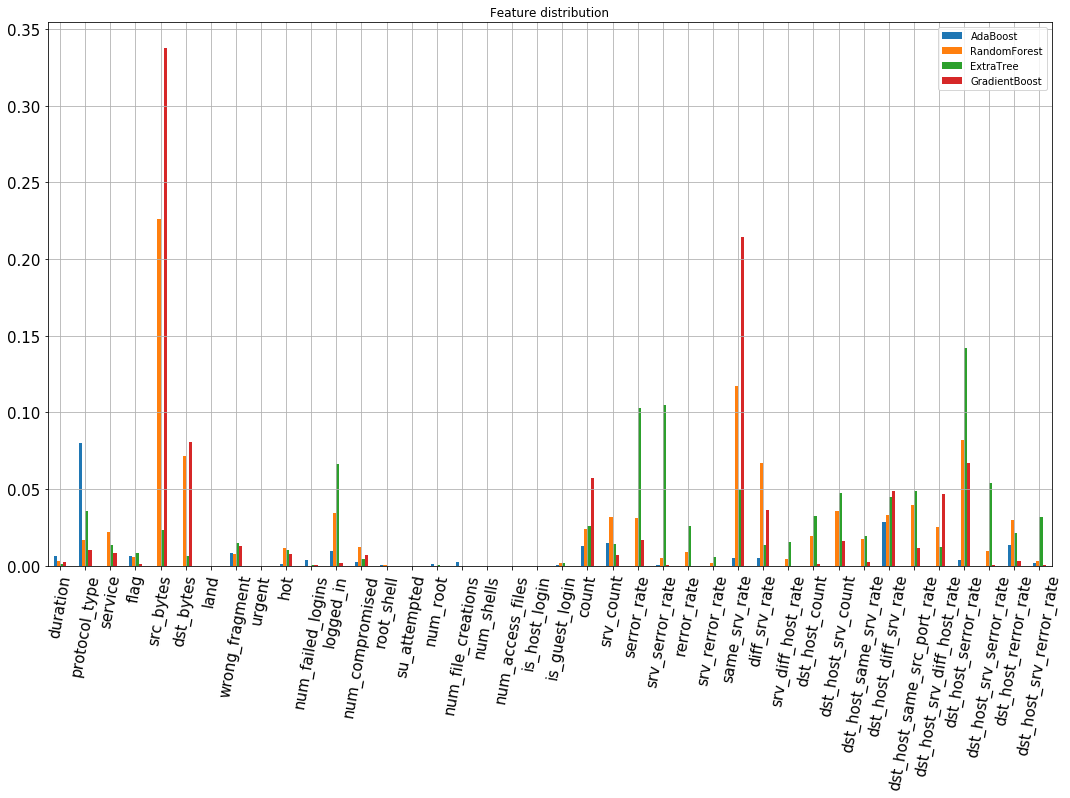

In [29]:
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

graph = feature_df.plot.bar(figsize = (18, 10), title = 'Feature distribution', grid=True, legend=True, fontsize = 15, 
                            xticks=feature_df.index)
graph.set_xticklabels(feature_df.features, rotation = 80)

#### Extract twelve features from each Ensemble model

In [30]:
a_f = feature_df.nlargest(12, 'AdaBoost')
e_f = feature_df.nlargest(12, 'ExtraTree')
g_f = feature_df.nlargest(12, 'GradientBoost')
r_f = feature_df.nlargest(12, 'RandomForest')

#### Delete Duplicates

In [31]:
result = pd.concat([a_f, e_f, g_f, r_f])
result = result.drop_duplicates() # delete duplicate feature
result

,features,AdaBoost,RandomForest,ExtraTree,GradientBoost
5,dst_bytes,inf,0.071350,0.006323,0.080590
1,protocol_type,0.079839,0.017053,0.036040,0.010060
33,dst_host_diff_srv_rate,0.028846,0.033443,0.044640,0.048724
22,srv_count,0.015008,0.031596,0.014470,0.007167
38,dst_host_rerror_rate,0.013621,0.029993,0.021374,0.003126
21,count,0.013028,0.024041,0.025923,0.057241
11,logged_in,0.009714,0.034661,0.066461,0.001940
7,wrong_fragment,0.008147,0.007525,0.015028,0.012979
0,duration,0.006689,0.002997,0.001453,0.002371
3,flag,0.006223,0.005469,0.008611,0.001260


In [32]:
selected_features = result['features'].values.tolist()
selected_features

['dst_bytes',
 'protocol_type',
 'dst_host_diff_srv_rate',
 'srv_count',
 'dst_host_rerror_rate',
 'count',
 'logged_in',
 'wrong_fragment',
 'duration',
 'flag',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_serror_rate',
 'srv_serror_rate',
 'serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_count',
 'dst_host_count',
 'dst_host_srv_rerror_rate',
 'src_bytes',
 'dst_host_srv_diff_host_rate']

#### Below are the results of training with the exception of the features with small standard deviations.

In [33]:
AB.fit(X_train_stdrop, Y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [34]:
ab2_score = AB.score(X_test_stdrop, Y_test)

print('AdaBoostClassifier_stdrop processing ,,,')
print('AdaBoostClasifier Score: %.3f %%' % ab2_score)

AdaBoostClassifier_stdrop processing ,,,
AdaBoostClasifier Score: 0.757 %


In [35]:
RF.fit(X_train_stdrop, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
rf2_score = RF.score(X_test_stdrop, Y_test)

print('RandomForestClassifier_stdrop processing ,,,')
print('RandomForestClassifier Score: %.3f %%' % rf2_score)

RandomForestClassifier_stdrop processing ,,,
RandomForestClassifier Score: 0.750 %


In [37]:
ET.fit(X_train_stdrop, Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [38]:
et2_score = ET.score(X_test_stdrop, Y_test)

print('ExtraTreesClassifier_stdrop processing ,,,')
print('ExtraTreesClassifier Score: %.3f %%' % et2_score)

ExtraTreesClassifier_stdrop processing ,,,
ExtraTreesClassifier Score: 0.761 %


In [39]:
GB.fit(X_train_stdrop, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [40]:
gb2_score = GB.score(X_test_stdrop, Y_test)

print('GradientBoostingClassifier_stdrop processing ,,,')
print('GradientBoostingClassifier Score: %.2f %%' % gb2_score)

GradientBoostingClassifier_stdrop processing ,,,
GradientBoostingClassifier Score: 0.76 %


#### Only features obtained through ensemble

In [41]:
X_train_ens = X_train[selected_features]
X_train_ens.head()

X_test_ens = X_test[selected_features]
X_test_ens.head()

,dst_bytes,protocol_type,dst_host_diff_srv_rate,srv_count,dst_host_rerror_rate,count,logged_in,wrong_fragment,duration,flag,same_srv_rate,diff_srv_rate,dst_host_serror_rate,srv_serror_rate,serror_rate,dst_host_srv_serror_rate,dst_host_same_src_port_rate,dst_host_srv_count,dst_host_count,dst_host_srv_rerror_rate,src_bytes,dst_host_srv_diff_host_rate
0,0,0,0.00,110,0.32,110,0,0,0,4,1.0,0.0,0.65,1.0,1.0,0.65,0.00,255,255,0.32,0,0.00
1,1856,0,0.00,9,0.00,1,1,0,0,2,1.0,0.0,0.00,0.0,0.0,0.00,1.00,254,1,0.00,312,0.06
2,2058,0,0.00,5,0.00,5,1,0,0,2,1.0,0.0,0.01,0.0,0.0,0.00,0.01,255,114,0.00,245,0.05
3,1267,0,0.00,18,0.00,4,1,0,0,2,1.0,0.0,0.00,0.0,0.0,0.00,0.00,255,255,0.00,298,0.00
4,0,0,0.03,1,0.00,1,0,0,0,2,1.0,0.0,0.00,0.0,0.0,0.00,0.18,19,104,0.00,740,0.00


### 3. Correlation
Features that have high correlation among multiple features (redundant features) 
are merged or deleted. This is because if there is a large correlation between these features, 
there is no need to increase the number of features.

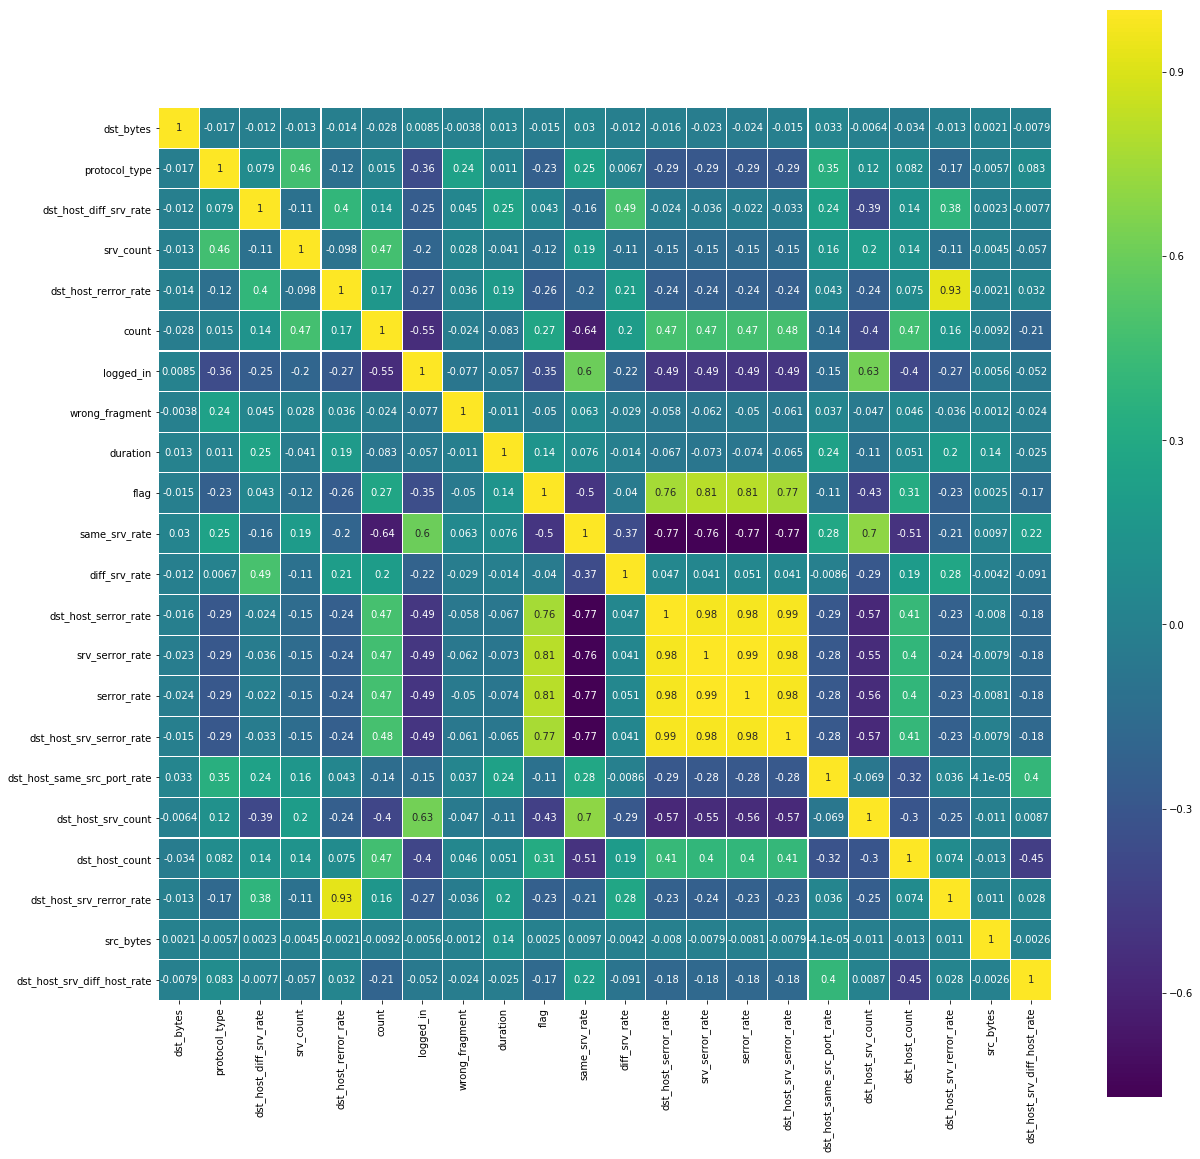

In [42]:
sample = X_train_ens[:10000]

colormap = plt.cm.viridis
plt.figure(figsize=(20, 20))
sns.heatmap(sample.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)

#### The above graph analysis shows that the dependency is high in the following features

In [43]:
selected2 = ['flag', 'dst_host_serror_rate', 'serror_rate']
X_train_cordrop = X_train_ens.drop(selected2, axis=1)
X_train_cordrop.describe()

X_test_cordrop = X_test_ens.drop(selected2, axis=1)
X_test_cordrop.describe()

,dst_bytes,protocol_type,dst_host_diff_srv_rate,srv_count,dst_host_rerror_rate,count,logged_in,wrong_fragment,duration,same_srv_rate,diff_srv_rate,srv_serror_rate,dst_host_srv_serror_rate,dst_host_same_src_port_rate,dst_host_srv_count,dst_host_count,dst_host_srv_rerror_rate,src_bytes,dst_host_srv_diff_host_rate
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,1.996999e+03,0.278600,0.089412,31.730900,0.236296,80.152400,0.436600,0.009000,229.263000,0.739925,0.089752,0.101696,0.097781,0.133167,139.645700,194.522200,0.230181,6.845032e+03,0.020102
std,2.006975e+04,0.657134,0.218190,90.353536,0.389137,129.028094,0.495989,0.146701,1461.180594,0.413711,0.252240,0.295464,0.279651,0.307154,111.548555,93.746065,0.403294,8.675409e+04,0.089353
min,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,15.000000,125.000000,0.000000,0.000000e+00,0.000000
50%,4.400000e+01,0.000000,0.020000,6.000000,0.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,159.500000,255.000000,0.000000,5.400000e+01,0.000000
75%,5.990000e+02,0.000000,0.060000,16.000000,0.390000,126.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,0.000000,0.030000,255.000000,255.000000,0.220000,2.850000e+02,0.010000
max,1.285078e+06,2.000000,1.000000,511.000000,1.000000,511.000000,1.000000,3.000000,57715.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,6.291668e+06,1.000000


## 2) Modeling

#### Modeling after completion of the feature selection process (elimination of low deviation, high correlation)
#### Comparing final modeling results with features that affect ensemble modeling

### Ensemble Modeling results with final modeling impact

In [44]:
AB.fit(X_train_cordrop, Y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [45]:
ab_finalscore = AB.score(X_test_cordrop, Y_test)

print('AdaBoostClassifier_final processing ,,,')
print('AdaBoostClassifier_final Score: %.3f %%' % ab_finalscore)

AdaBoostClassifier_final processing ,,,
AdaBoostClassifier_final Score: 0.732 %


In [46]:
RF.fit(X_train_cordrop, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
rf_finalscore = RF.score(X_test_cordrop, Y_test)

print('RandomForestClassifier_final processing ,,,')
print('RandomForestClassifier_final Score: %.3f %%' % rf_finalscore)

RandomForestClassifier_final processing ,,,
RandomForestClassifier_final Score: 0.754 %


In [48]:
ET.fit(X_train_cordrop, Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [49]:
et_finalscore = ET.score(X_test_cordrop, Y_test)

print('ExtraTreesClassifier_final processing ,,,')
print('ExtraTreesClassifier_final Score: %.3f %%' % et_finalscore)

ExtraTreesClassifier_final processing ,,,
ExtraTreesClassifier_final Score: 0.751 %


In [50]:
GB.fit(X_train_cordrop, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [51]:
gb_finalscore = GB.score(X_test_cordrop, Y_test)

print('GradientBoostClassifier_final processing ,,,')
print('GradientBoostClassifier_final Score: %.3f %%' % gb_finalscore)

GradientBoostClassifier_final processing ,,,
GradientBoostClassifier_final Score: 0.749 %


In [52]:
LR.fit(X_train_cordrop, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [53]:
lr_finalscore = LR.score(X_test_cordrop, Y_test)

print('LinearRegression_final processing ,,,')
print('LinearRegression_final Score: %.3f %%' % lr_finalscore)

LinearRegression_final processing ,,,
LinearRegression_final Score: 0.294 %


In [54]:
from sklearn.neural_network import MLPClassifier

In [55]:
MLP = MLPClassifier(hidden_layer_sizes=(1000, 300, 300), solver='adam', shuffle=False, tol = 0.0001)

In [56]:
MLP.fit(X_train_cordrop, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 300, 300), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=False, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [57]:
mlp_finalscore = MLP.score(X_test_cordrop, Y_test)

print('MLP_final processing ,,,')
print('MLP_final Score: %.3f %%' % mlp_finalscore)

MLP_final processing ,,,
MLP_final Score: 0.744 %


## 3) Result

As a result, feature selection and extraction did not result in high probability. I have seen 1-2% increase in accuracy, but I think the feature will be reduced and it will be able to operate a little faster and will prevent overfitting when new data comes in.

Comparing the score of each model

- first models

In [58]:
first_model = {'Model': ['Linear Regression', 'Adaboost', 'RandomForest', 'ExtraTrees', 'GradientBoost'],
               'accuracy' : [lr_score, ab_score, rf_score, et_score, gb_score]}

result_df = pd.DataFrame(data = first_model)
result_df

,Model,accuracy
0,Linear Regression,0.334265
1,Adaboost,0.759700
2,RandomForest,0.754300
3,ExtraTrees,0.749600
4,GradientBoost,0.763500


[Text(0,0,'Linear Regression'),
 Text(0,0,'Adaboost'),
 Text(0,0,'RandomForest'),
 Text(0,0,'ExtraTrees'),
 Text(0,0,'GradientBoost')]

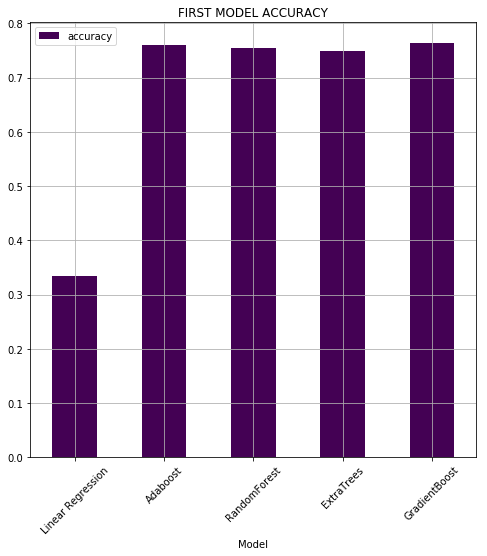

In [59]:
r1 = result_df.plot(x='Model', y='accuracy', kind='bar', figsize=(8, 8), grid=True, title='FIRST MODEL ACCURACY', colormap=plt.cm.viridis,
               sort_columns=True)
r1.set_xticklabels(result_df.Model, rotation = 45)

- second models

In [60]:
second_model = {'Model': ['Adaboost', 'RandomForest', 'ExtraTrees', 'GradientBoost'],
               'accuracy' : [ab2_score, rf2_score, et2_score, gb2_score]}

result_df = pd.DataFrame(data = second_model)
result_df

,Model,accuracy
0,Adaboost,0.7569
1,RandomForest,0.7498
2,ExtraTrees,0.7610
3,GradientBoost,0.7612


[Text(0,0,'Adaboost'),
 Text(0,0,'RandomForest'),
 Text(0,0,'ExtraTrees'),
 Text(0,0,'GradientBoost')]

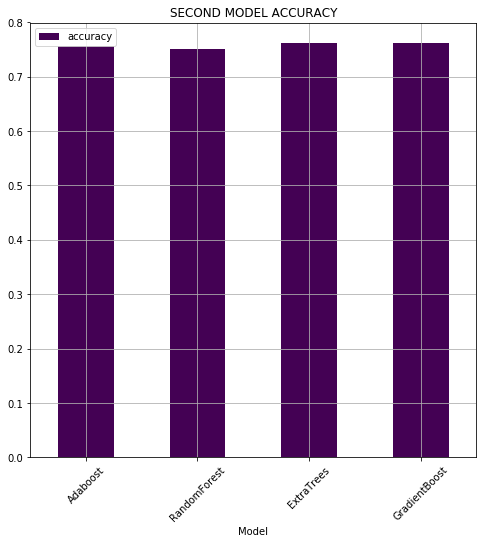

In [61]:
r2 = result_df.plot(x='Model', y='accuracy', kind='bar', figsize=(8, 8), grid=True, title='SECOND MODEL ACCURACY', colormap=plt.cm.viridis,
               sort_columns=True)
r2.set_xticklabels(result_df.Model, rotation = 45)

- final models

In [62]:
final_model = {'Model': ['Linear Regression', 'Adaboost', 'RandomForest', 'ExtraTrees', 'GradientBoost', 'MLP'],
               'accuracy' : [lr_finalscore, ab_finalscore, rf_finalscore, et_finalscore, gb_finalscore, mlp_finalscore]}

result_df = pd.DataFrame(data = final_model)
result_df

,Model,accuracy
0,Linear Regression,0.294329
1,Adaboost,0.732000
2,RandomForest,0.754200
3,ExtraTrees,0.751400
4,GradientBoost,0.749100
5,MLP,0.744300


[Text(0,0,'Linear Regression'),
 Text(0,0,'Adaboost'),
 Text(0,0,'RandomForest'),
 Text(0,0,'ExtraTrees'),
 Text(0,0,'GradientBoost'),
 Text(0,0,'MLP')]

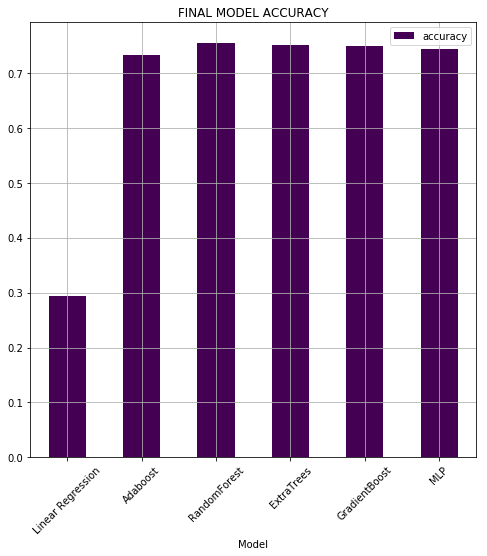

In [63]:
r3 = result_df.plot(x='Model', y='accuracy', kind='bar', figsize=(8, 8), grid=True, title='FINAL MODEL ACCURACY', colormap=plt.cm.viridis,
               sort_columns=True)
r3.set_xticklabels(result_df.Model, rotation = 45)

## FASTEST AND ACCURATE MODEL - ExtraTrees of the final model (76.4%)
## STRONGEST AND THE MOST ACCURATE MODEL - GradientBoost of the final model (77.1%)

Gradient boost has a 77 percent chance, but the speed is significantly faster with ExtraTress.